# Keras入门1

Keras是一个高层神经网络API，可以运行在Tensorflow、Theano以及CNTK等框架上。Keras的优点是简洁，建模速度快，上手容易。如果已经对神经网络有了基础的了解，基于Keras可以快速帮你构架起模型来。也是因为Keras的高度抽象性，对于一些特别复杂的模型个别功能受限，但是对于大多数情况下，Keras已经足够好用了。

本文基于一个多变量线性模型的数据，分别由Tensorflow和Keras建立模型进行优化求解，从中你可以对于Tensorflow和Keras的区别，并且感受到Keras带来的便利。

## 多变量线性模型

现在有一个任务——让机器帮我们找到收入与IQ，工作经验和年龄的关系。为了便于演示和理解，数据是事先“制造”出来的。收入肯定和人的聪明程度有关系，但也不是智商最高的人收入最高，还有一个很重要的因素是工作年限和年龄，假设有这样一个关系：

$$income = 0.3*iq + 1.5*experiece + 0.83*age + 5 + noise$$

先来随机生成一批数据，然后对数据进行"清洗"，要求工作经验不能小于0，年龄不能小于22岁。过滤后数据就整理好了


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create dataset
np.random.seed(555)
samples = 1000
iq = np.random.normal(100, 20, samples).astype(int) # IQ
user_exp = np.random.normal(20, 10, samples)
age = np.random.normal(40, 15, samples).astype(int) # age

b = 5
noise = np.random.normal(0, 2, samples)

Y = 0.3 * iq + 1.5 * user_exp + 0.83 * age + b + noise

In [3]:
cols = ['iq', 'years_experience', 'age']
df = pd.DataFrame(list(zip(iq, user_exp, age)), columns=cols)
df['income'] = Y

In [4]:
df = df[df.years_experience >= 0]
df = df[df.age >= 22]
df.describe()

,iq,years_experience,age,income
count,873.000000,873.000000,873.000000,873.000000
mean,98.920962,20.679737,42.686140,101.101279
std,20.283697,9.542625,12.357908,18.482897
min,29.000000,0.121086,22.000000,52.322404
25%,86.000000,13.581315,33.000000,87.352662
50%,100.000000,20.658120,42.000000,100.927100
75%,112.000000,27.110924,51.000000,113.778953
max,156.000000,52.890748,84.000000,155.697898


整理好数据后分出训练和测试集，使用sklearn的train_test_split方法

In [5]:
from sklearn.model_selection import train_test_split
x_data = df[['iq', 'years_experience', 'age']]
y_val =  df[['income']]
X_train, X_test, y_train, y_test = train_test_split(x_data,y_val,test_size=0.20, random_state=101)

## 使用Tensorflow实现线性模型

我们先手工使用TensorFlor实现一个Linear Regressor，还实现minibatch函数

In [6]:
import math
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
# init graph
tf.reset_default_graph()

#create vars
W = tf.get_variable('W', [3,1], initializer = tf.zeros_initializer())
b = tf.get_variable('b', [1,1], initializer = tf.zeros_initializer())

# create input placeholders
X = tf.placeholder('float32', name='X')
Y = tf.placeholder('float32', name='Y_true')

# create linear model
#yhat = tf.reshape(tf.matmul(X,W) + b, [-1,], name='yhat')
yhat = tf.matmul(X,W) + b

mse = tf.reduce_mean(tf.squared_difference(Y, yhat), name='mse')

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(mse)

Cost after epoch 0: 8349.256727
Cost in test set after epoch 0: 9753.441961
Cost after epoch 100: 73.009706
Cost in test set after epoch 100: 68.277555
Cost after epoch 200: 16.396915
Cost in test set after epoch 200: 15.680660
Cost after epoch 300: 3.585278
Cost in test set after epoch 300: 4.647265
Cost after epoch 400: 3.445812
Cost in test set after epoch 400: 4.557039
Weights : [array([[0.31692702],
       [1.5301745 ],
       [0.85716254]], dtype=float32), array([[1.4373599]], dtype=float32)]


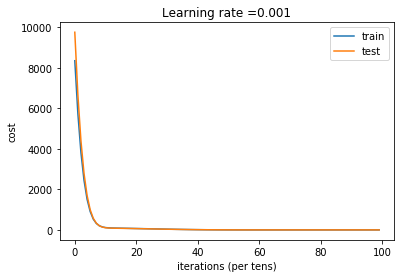

Cost on the test set is 4.4552490331308245


In [8]:
from sklearn import metrics  
def predict_cost(W, b, x_test, y_test):
    y_pred = x_test @ W + b
    return metrics.mean_squared_error(y_pred, y_test)
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    # init vars
    sess.run(init)
    num_epochs = 500
    minibatch_size = 32
    print_cost = True
    m = x_data.shape[0]
    costs = []
    pred_costs = []
    seed = 100
    
    for epoch in range(num_epochs):

        epoch_cost = 0.                       # Defines a cost related to an epoch
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        #print(num_minibatches)
        seed = seed + 1
        minibatches = random_mini_batches(X_train.values, y_train.values, minibatch_size, seed)

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            _, minibatch_cost = sess.run([optimizer, mse], feed_dict={X: minibatch_X, Y: minibatch_Y})
            
            epoch_cost += minibatch_cost / num_minibatches
            
        # Print the cost every epoch
        if print_cost == True and epoch % 100 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
            Wt, bt = sess.run([W,b])
            pred_cost = predict_cost(Wt, bt, X_test.values, y_test.values )                  
            print ("Cost in test set after epoch %i: %f" % (epoch, pred_cost))   
                
                
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)
            
            Wt, bt = sess.run([W,b])
            pred_cost = predict_cost(Wt, bt, X_test.values, y_test.values )
            pred_costs.append(pred_cost)
            
    # plot the cost
    print("Weights : {}".format(sess.run([W,b])))
    plt.plot(np.squeeze(costs), label="train")
    plt.plot(np.squeeze(pred_costs), label="test")
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend()
    plt.show()
    
    Wt, bt = sess.run([W,b])
    pred_cost = predict_cost(Wt, bt, X_test.values, y_test.values )
    print("Cost on the test set is {}".format(pred_cost))
    

## Keras模型

Keras建模主要有几下几步：
1. 使用Keras内置的API实现前向传播计算方法
2. Compile the model by calling model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])
3. Train the model on train data by calling model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)
4. Test the model on test data by calling model.evaluate(x = ..., y = ...)

In [9]:
from keras import layers
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from keras.models import Model
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [10]:
def linearModel(input_shape):

    X_input = Input(input_shape)
    X = Dense(1, activation='linear', name='fc')(X_input)
    
    model = Model(inputs = X_input, outputs = X, name='linearModel')
    
    return model

In [11]:
model = linearModel(X_train.shape[1:])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


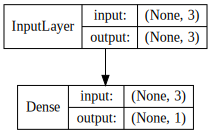

In [13]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [14]:
#opt =  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer = "adam", loss = "mean_absolute_error", metrics = ["accuracy"])

In [15]:
history = model.fit(x = X_train.values, y = y_train.values, epochs = 500, 
                    verbose=1, batch_size = 32, shuffle=True, 
                    validation_data = (X_test.values, y_test.values) )

Train on 698 samples, validate on 175 samples
Epoch 1/500
698/698 [==============================] - 0s 207us/step - loss: 15.2865 - acc: 0.0000e+00 - val_loss: 13.3328 - val_acc: 0.0000e+00
Epoch 2/500
698/698 [==============================] - 0s 31us/step - loss: 13.4568 - acc: 0.0000e+00 - val_loss: 11.8061 - val_acc: 0.0000e+00
Epoch 3/500
698/698 [==============================] - 0s 33us/step - loss: 12.2828 - acc: 0.0000e+00 - val_loss: 10.8707 - val_acc: 0.0000e+00
Epoch 4/500
698/698 [==============================] - 0s 32us/step - loss: 11.6250 - acc: 0.0000e+00 - val_loss: 10.3064 - val_acc: 0.0000e+00
Epoch 5/500
698/698 [==============================] - 0s 32us/step - loss: 11.2661 - acc: 0.0000e+00 - val_loss: 9.9996 - val_acc: 0.0000e+00
Epoch 6/500
698/698 [==============================] - 0s 31us/step - loss: 11.0505 - acc: 0.0000e+00 - val_loss: 9.7950 - val_acc: 0.0000e+00
Epoch 7/500
698/698 [==============================] - 0s 31us/step - loss: 10.8991 - acc: 

Epoch 58/500
698/698 [==============================] - 0s 31us/step - loss: 2.0567 - acc: 0.0000e+00 - val_loss: 1.9568 - val_acc: 0.0000e+00
Epoch 59/500
698/698 [==============================] - 0s 30us/step - loss: 1.9814 - acc: 0.0000e+00 - val_loss: 1.9018 - val_acc: 0.0000e+00
Epoch 60/500
698/698 [==============================] - 0s 30us/step - loss: 1.9230 - acc: 0.0000e+00 - val_loss: 1.8701 - val_acc: 0.0000e+00
Epoch 61/500
698/698 [==============================] - 0s 30us/step - loss: 1.8887 - acc: 0.0000e+00 - val_loss: 1.8746 - val_acc: 0.0000e+00
Epoch 62/500
698/698 [==============================] - 0s 29us/step - loss: 1.8197 - acc: 0.0000e+00 - val_loss: 1.8119 - val_acc: 0.0000e+00
Epoch 63/500
698/698 [==============================] - 0s 34us/step - loss: 1.7850 - acc: 0.0000e+00 - val_loss: 1.8116 - val_acc: 0.0000e+00
Epoch 64/500
698/698 [==============================] - 0s 31us/step - loss: 1.7535 - acc: 0.0000e+00 - val_loss: 1.7961 - val_acc: 0.0000e+00

698/698 [==============================] - 0s 29us/step - loss: 1.6387 - acc: 0.0000e+00 - val_loss: 1.8031 - val_acc: 0.0000e+00
Epoch 116/500
698/698 [==============================] - 0s 26us/step - loss: 1.6363 - acc: 0.0000e+00 - val_loss: 1.8078 - val_acc: 0.0000e+00
Epoch 117/500
698/698 [==============================] - 0s 29us/step - loss: 1.6353 - acc: 0.0000e+00 - val_loss: 1.7966 - val_acc: 0.0000e+00
Epoch 118/500
698/698 [==============================] - 0s 30us/step - loss: 1.6365 - acc: 0.0000e+00 - val_loss: 1.8132 - val_acc: 0.0000e+00
Epoch 119/500
698/698 [==============================] - 0s 30us/step - loss: 1.6367 - acc: 0.0000e+00 - val_loss: 1.8029 - val_acc: 0.0000e+00
Epoch 120/500
698/698 [==============================] - 0s 30us/step - loss: 1.6365 - acc: 0.0000e+00 - val_loss: 1.7922 - val_acc: 0.0000e+00
Epoch 121/500
698/698 [==============================] - 0s 32us/step - loss: 1.6443 - acc: 0.0000e+00 - val_loss: 1.8013 - val_acc: 0.0000e+00
Epoch 

Epoch 172/500
698/698 [==============================] - 0s 30us/step - loss: 1.6214 - acc: 0.0000e+00 - val_loss: 1.7831 - val_acc: 0.0000e+00
Epoch 173/500
698/698 [==============================] - 0s 29us/step - loss: 1.6199 - acc: 0.0000e+00 - val_loss: 1.7837 - val_acc: 0.0000e+00
Epoch 174/500
698/698 [==============================] - 0s 33us/step - loss: 1.6217 - acc: 0.0000e+00 - val_loss: 1.8081 - val_acc: 0.0000e+00
Epoch 175/500
698/698 [==============================] - 0s 30us/step - loss: 1.6207 - acc: 0.0000e+00 - val_loss: 1.7951 - val_acc: 0.0000e+00
Epoch 176/500
698/698 [==============================] - 0s 30us/step - loss: 1.6223 - acc: 0.0000e+00 - val_loss: 1.8132 - val_acc: 0.0000e+00
Epoch 177/500
698/698 [==============================] - 0s 31us/step - loss: 1.6171 - acc: 0.0000e+00 - val_loss: 1.7702 - val_acc: 0.0000e+00
Epoch 178/500
698/698 [==============================] - 0s 31us/step - loss: 1.6151 - acc: 0.0000e+00 - val_loss: 1.7952 - val_acc: 0.0

698/698 [==============================] - 0s 34us/step - loss: 1.6051 - acc: 0.0000e+00 - val_loss: 1.7585 - val_acc: 0.0000e+00
Epoch 229/500
698/698 [==============================] - 0s 32us/step - loss: 1.6065 - acc: 0.0000e+00 - val_loss: 1.8058 - val_acc: 0.0000e+00
Epoch 230/500
698/698 [==============================] - 0s 32us/step - loss: 1.6077 - acc: 0.0000e+00 - val_loss: 1.7566 - val_acc: 0.0000e+00
Epoch 231/500
698/698 [==============================] - 0s 29us/step - loss: 1.6043 - acc: 0.0000e+00 - val_loss: 1.7637 - val_acc: 0.0000e+00
Epoch 232/500
698/698 [==============================] - 0s 28us/step - loss: 1.6091 - acc: 0.0000e+00 - val_loss: 1.7654 - val_acc: 0.0000e+00
Epoch 233/500
698/698 [==============================] - 0s 38us/step - loss: 1.6021 - acc: 0.0000e+00 - val_loss: 1.7789 - val_acc: 0.0000e+00
Epoch 234/500
698/698 [==============================] - 0s 34us/step - loss: 1.6067 - acc: 0.0000e+00 - val_loss: 1.7637 - val_acc: 0.0000e+00
Epoch 

Epoch 285/500
698/698 [==============================] - 0s 29us/step - loss: 1.5877 - acc: 0.0000e+00 - val_loss: 1.7440 - val_acc: 0.0000e+00
Epoch 286/500
698/698 [==============================] - 0s 28us/step - loss: 1.5884 - acc: 0.0000e+00 - val_loss: 1.7839 - val_acc: 0.0000e+00
Epoch 287/500
698/698 [==============================] - 0s 29us/step - loss: 1.5968 - acc: 0.0000e+00 - val_loss: 1.7404 - val_acc: 0.0000e+00
Epoch 288/500
698/698 [==============================] - 0s 35us/step - loss: 1.5892 - acc: 0.0000e+00 - val_loss: 1.7697 - val_acc: 0.0000e+00
Epoch 289/500
698/698 [==============================] - 0s 34us/step - loss: 1.5901 - acc: 0.0000e+00 - val_loss: 1.7469 - val_acc: 0.0000e+00
Epoch 290/500
698/698 [==============================] - 0s 34us/step - loss: 1.5987 - acc: 0.0000e+00 - val_loss: 1.7424 - val_acc: 0.0000e+00
Epoch 291/500
698/698 [==============================] - 0s 34us/step - loss: 1.5878 - acc: 0.0000e+00 - val_loss: 1.7647 - val_acc: 0.0

Epoch 342/500
698/698 [==============================] - 0s 29us/step - loss: 1.5862 - acc: 0.0000e+00 - val_loss: 1.7272 - val_acc: 0.0000e+00
Epoch 343/500
698/698 [==============================] - 0s 30us/step - loss: 1.5844 - acc: 0.0000e+00 - val_loss: 1.7282 - val_acc: 0.0000e+00
Epoch 344/500
698/698 [==============================] - 0s 30us/step - loss: 1.5782 - acc: 0.0000e+00 - val_loss: 1.7458 - val_acc: 0.0000e+00
Epoch 345/500
698/698 [==============================] - 0s 31us/step - loss: 1.5973 - acc: 0.0000e+00 - val_loss: 1.7241 - val_acc: 0.0000e+00
Epoch 346/500
698/698 [==============================] - 0s 28us/step - loss: 1.5759 - acc: 0.0000e+00 - val_loss: 1.7728 - val_acc: 0.0000e+00
Epoch 347/500
698/698 [==============================] - 0s 29us/step - loss: 1.5840 - acc: 0.0000e+00 - val_loss: 1.7312 - val_acc: 0.0000e+00
Epoch 348/500
698/698 [==============================] - 0s 32us/step - loss: 1.5738 - acc: 0.0000e+00 - val_loss: 1.7442 - val_acc: 0.0

Epoch 399/500
698/698 [==============================] - 0s 32us/step - loss: 1.5902 - acc: 0.0000e+00 - val_loss: 1.7869 - val_acc: 0.0000e+00
Epoch 400/500
698/698 [==============================] - 0s 36us/step - loss: 1.5615 - acc: 0.0000e+00 - val_loss: 1.7144 - val_acc: 0.0000e+00
Epoch 401/500
698/698 [==============================] - 0s 33us/step - loss: 1.5684 - acc: 0.0000e+00 - val_loss: 1.7514 - val_acc: 0.0000e+00
Epoch 402/500
698/698 [==============================] - 0s 39us/step - loss: 1.5691 - acc: 0.0000e+00 - val_loss: 1.7420 - val_acc: 0.0000e+00
Epoch 403/500
698/698 [==============================] - 0s 46us/step - loss: 1.5730 - acc: 0.0000e+00 - val_loss: 1.7714 - val_acc: 0.0000e+00
Epoch 404/500
698/698 [==============================] - 0s 31us/step - loss: 1.5634 - acc: 0.0000e+00 - val_loss: 1.7132 - val_acc: 0.0000e+00
Epoch 405/500
698/698 [==============================] - 0s 36us/step - loss: 1.5758 - acc: 0.0000e+00 - val_loss: 1.7380 - val_acc: 0.0

Epoch 456/500
698/698 [==============================] - 0s 31us/step - loss: 1.5576 - acc: 0.0000e+00 - val_loss: 1.7239 - val_acc: 0.0000e+00
Epoch 457/500
698/698 [==============================] - 0s 26us/step - loss: 1.5638 - acc: 0.0000e+00 - val_loss: 1.7099 - val_acc: 0.0000e+00
Epoch 458/500
698/698 [==============================] - 0s 31us/step - loss: 1.5643 - acc: 0.0000e+00 - val_loss: 1.7246 - val_acc: 0.0000e+00
Epoch 459/500
698/698 [==============================] - 0s 31us/step - loss: 1.5615 - acc: 0.0000e+00 - val_loss: 1.7035 - val_acc: 0.0000e+00
Epoch 460/500
698/698 [==============================] - 0s 28us/step - loss: 1.5616 - acc: 0.0000e+00 - val_loss: 1.7319 - val_acc: 0.0000e+00
Epoch 461/500
698/698 [==============================] - 0s 28us/step - loss: 1.5564 - acc: 0.0000e+00 - val_loss: 1.7146 - val_acc: 0.0000e+00
Epoch 462/500
698/698 [==============================] - 0s 31us/step - loss: 1.5566 - acc: 0.0000e+00 - val_loss: 1.7131 - val_acc: 0.0

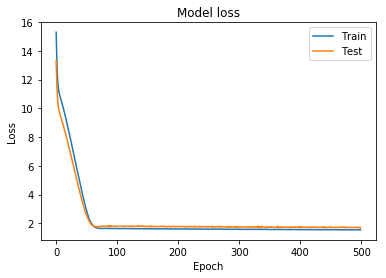

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [17]:
model.get_weights()

[array([[0.31132033],
        [1.5263102 ],
        [0.8499537 ]], dtype=float32), array([2.5805793], dtype=float32)]

In [18]:
### START CODE HERE ### (1 line)
preds = model.evaluate(X_test.values, y_test.values)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

175/175 [==============================] - 0s 25us/step

Loss = 1.6967269291196552
Test Accuracy = 0.0


## Keras的Shallow NN

Keras的优势是实现各种尝试神经网络，下面就是增加一层后形成了一个Shallow NN的模型

In [19]:
def shallowNnModel(input_shape):

    X_input = Input(input_shape)
    X = Dense(3, activation='relu', name='fc1')(X_input)
    X = Dense(1, activation='linear', name='fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='shallowNnModel')
    
    return model

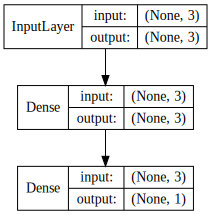

In [20]:
model = shallowNnModel(X_train.shape[1:])
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [21]:
#opt =  Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer = "adam", loss = "mean_absolute_error", metrics = ["accuracy"])
history = model.fit(x = X_train.values, y = y_train.values, epochs = 500, 
                    verbose=1, batch_size = 32, shuffle=True, 
                    validation_data = (X_test.values, y_test.values) )

Train on 698 samples, validate on 175 samples
Epoch 1/500
698/698 [==============================] - 0s 254us/step - loss: 68.1627 - acc: 0.0000e+00 - val_loss: 63.8648 - val_acc: 0.0000e+00
Epoch 2/500
698/698 [==============================] - 0s 34us/step - loss: 61.7588 - acc: 0.0000e+00 - val_loss: 56.9007 - val_acc: 0.0000e+00
Epoch 3/500
698/698 [==============================] - 0s 38us/step - loss: 54.0074 - acc: 0.0000e+00 - val_loss: 48.6594 - val_acc: 0.0000e+00
Epoch 4/500
698/698 [==============================] - 0s 35us/step - loss: 45.5663 - acc: 0.0000e+00 - val_loss: 39.2669 - val_acc: 0.0000e+00
Epoch 5/500
698/698 [==============================] - 0s 35us/step - loss: 37.3688 - acc: 0.0000e+00 - val_loss: 31.4321 - val_acc: 0.0000e+00
Epoch 6/500
698/698 [==============================] - 0s 35us/step - loss: 31.0429 - acc: 0.0000e+00 - val_loss: 26.3482 - val_acc: 0.0000e+00
Epoch 7/500
698/698 [==============================] - 0s 36us/step - loss: 27.6190 - acc

698/698 [==============================] - 0s 37us/step - loss: 9.2503 - acc: 0.0000e+00 - val_loss: 7.5270 - val_acc: 0.0000e+00
Epoch 58/500
698/698 [==============================] - 0s 34us/step - loss: 8.9095 - acc: 0.0000e+00 - val_loss: 7.2956 - val_acc: 0.0000e+00
Epoch 59/500
698/698 [==============================] - 0s 36us/step - loss: 8.6364 - acc: 0.0000e+00 - val_loss: 7.0399 - val_acc: 0.0000e+00
Epoch 60/500
698/698 [==============================] - 0s 36us/step - loss: 8.3182 - acc: 0.0000e+00 - val_loss: 6.7870 - val_acc: 0.0000e+00
Epoch 61/500
698/698 [==============================] - 0s 37us/step - loss: 7.9987 - acc: 0.0000e+00 - val_loss: 6.5301 - val_acc: 0.0000e+00
Epoch 62/500
698/698 [==============================] - 0s 43us/step - loss: 7.6754 - acc: 0.0000e+00 - val_loss: 6.2711 - val_acc: 0.0000e+00
Epoch 63/500
698/698 [==============================] - 0s 54us/step - loss: 7.3512 - acc: 0.0000e+00 - val_loss: 6.0033 - val_acc: 0.0000e+00
Epoch 64/500

698/698 [==============================] - 0s 33us/step - loss: 1.6036 - acc: 0.0000e+00 - val_loss: 1.7506 - val_acc: 0.0000e+00
Epoch 115/500
698/698 [==============================] - 0s 33us/step - loss: 1.5955 - acc: 0.0000e+00 - val_loss: 1.7388 - val_acc: 0.0000e+00
Epoch 116/500
698/698 [==============================] - 0s 38us/step - loss: 1.5979 - acc: 0.0000e+00 - val_loss: 1.7510 - val_acc: 0.0000e+00
Epoch 117/500
698/698 [==============================] - 0s 32us/step - loss: 1.5915 - acc: 0.0000e+00 - val_loss: 1.8498 - val_acc: 0.0000e+00
Epoch 118/500
698/698 [==============================] - 0s 40us/step - loss: 1.6198 - acc: 0.0000e+00 - val_loss: 1.7426 - val_acc: 0.0000e+00
Epoch 119/500
698/698 [==============================] - 0s 36us/step - loss: 1.5987 - acc: 0.0000e+00 - val_loss: 1.7917 - val_acc: 0.0000e+00
Epoch 120/500
698/698 [==============================] - 0s 35us/step - loss: 1.6122 - acc: 0.0000e+00 - val_loss: 1.7930 - val_acc: 0.0000e+00
Epoch 

Epoch 171/500
698/698 [==============================] - 0s 42us/step - loss: 1.5664 - acc: 0.0000e+00 - val_loss: 1.7392 - val_acc: 0.0000e+00
Epoch 172/500
698/698 [==============================] - 0s 40us/step - loss: 1.5728 - acc: 0.0000e+00 - val_loss: 1.7478 - val_acc: 0.0000e+00
Epoch 173/500
698/698 [==============================] - 0s 43us/step - loss: 1.5698 - acc: 0.0000e+00 - val_loss: 1.7266 - val_acc: 0.0000e+00
Epoch 174/500
698/698 [==============================] - 0s 44us/step - loss: 1.5671 - acc: 0.0000e+00 - val_loss: 1.7236 - val_acc: 0.0000e+00
Epoch 175/500
698/698 [==============================] - 0s 38us/step - loss: 1.5865 - acc: 0.0000e+00 - val_loss: 1.7277 - val_acc: 0.0000e+00
Epoch 176/500
698/698 [==============================] - 0s 40us/step - loss: 1.5737 - acc: 0.0000e+00 - val_loss: 1.7211 - val_acc: 0.0000e+00
Epoch 177/500
698/698 [==============================] - 0s 34us/step - loss: 1.5752 - acc: 0.0000e+00 - val_loss: 1.7147 - val_acc: 0.0

Epoch 228/500
698/698 [==============================] - 0s 32us/step - loss: 1.5475 - acc: 0.0000e+00 - val_loss: 1.8004 - val_acc: 0.0000e+00
Epoch 229/500
698/698 [==============================] - 0s 33us/step - loss: 1.5638 - acc: 0.0000e+00 - val_loss: 1.6898 - val_acc: 0.0000e+00
Epoch 230/500
698/698 [==============================] - 0s 35us/step - loss: 1.5464 - acc: 0.0000e+00 - val_loss: 1.7217 - val_acc: 0.0000e+00
Epoch 231/500
698/698 [==============================] - 0s 35us/step - loss: 1.5418 - acc: 0.0000e+00 - val_loss: 1.6884 - val_acc: 0.0000e+00
Epoch 232/500
698/698 [==============================] - 0s 31us/step - loss: 1.5591 - acc: 0.0000e+00 - val_loss: 1.7605 - val_acc: 0.0000e+00
Epoch 233/500
698/698 [==============================] - 0s 36us/step - loss: 1.5497 - acc: 0.0000e+00 - val_loss: 1.7236 - val_acc: 0.0000e+00
Epoch 234/500
698/698 [==============================] - 0s 35us/step - loss: 1.5292 - acc: 0.0000e+00 - val_loss: 1.7598 - val_acc: 0.0

698/698 [==============================] - 0s 32us/step - loss: 1.5332 - acc: 0.0000e+00 - val_loss: 1.6990 - val_acc: 0.0000e+00
Epoch 285/500
698/698 [==============================] - 0s 32us/step - loss: 1.5223 - acc: 0.0000e+00 - val_loss: 1.6798 - val_acc: 0.0000e+00
Epoch 286/500
698/698 [==============================] - 0s 39us/step - loss: 1.5358 - acc: 0.0000e+00 - val_loss: 1.6895 - val_acc: 0.0000e+00
Epoch 287/500
698/698 [==============================] - 0s 31us/step - loss: 1.5699 - acc: 0.0000e+00 - val_loss: 1.7788 - val_acc: 0.0000e+00
Epoch 288/500
698/698 [==============================] - 0s 33us/step - loss: 1.5394 - acc: 0.0000e+00 - val_loss: 1.6878 - val_acc: 0.0000e+00
Epoch 289/500
698/698 [==============================] - 0s 33us/step - loss: 1.5257 - acc: 0.0000e+00 - val_loss: 1.6818 - val_acc: 0.0000e+00
Epoch 290/500
698/698 [==============================] - 0s 33us/step - loss: 1.5263 - acc: 0.0000e+00 - val_loss: 1.6818 - val_acc: 0.0000e+00
Epoch 

Epoch 341/500
698/698 [==============================] - 0s 36us/step - loss: 1.5080 - acc: 0.0000e+00 - val_loss: 1.6647 - val_acc: 0.0000e+00
Epoch 342/500
698/698 [==============================] - 0s 39us/step - loss: 1.5314 - acc: 0.0000e+00 - val_loss: 1.7099 - val_acc: 0.0000e+00
Epoch 343/500
698/698 [==============================] - 0s 36us/step - loss: 1.5717 - acc: 0.0000e+00 - val_loss: 1.8114 - val_acc: 0.0000e+00
Epoch 344/500
698/698 [==============================] - 0s 34us/step - loss: 1.5273 - acc: 0.0000e+00 - val_loss: 1.7016 - val_acc: 0.0000e+00
Epoch 345/500
698/698 [==============================] - 0s 34us/step - loss: 1.5158 - acc: 0.0000e+00 - val_loss: 1.7487 - val_acc: 0.0000e+00
Epoch 346/500
698/698 [==============================] - 0s 36us/step - loss: 1.5163 - acc: 0.0000e+00 - val_loss: 1.6674 - val_acc: 0.0000e+00
Epoch 347/500
698/698 [==============================] - 0s 38us/step - loss: 1.5067 - acc: 0.0000e+00 - val_loss: 1.7063 - val_acc: 0.0

Epoch 398/500
698/698 [==============================] - 0s 36us/step - loss: 1.5135 - acc: 0.0000e+00 - val_loss: 1.6913 - val_acc: 0.0000e+00
Epoch 399/500
698/698 [==============================] - 0s 35us/step - loss: 1.5378 - acc: 0.0000e+00 - val_loss: 1.6702 - val_acc: 0.0000e+00
Epoch 400/500
698/698 [==============================] - 0s 38us/step - loss: 1.5135 - acc: 0.0000e+00 - val_loss: 1.6790 - val_acc: 0.0000e+00
Epoch 401/500
698/698 [==============================] - 0s 37us/step - loss: 1.5100 - acc: 0.0000e+00 - val_loss: 1.6617 - val_acc: 0.0000e+00
Epoch 402/500
698/698 [==============================] - 0s 34us/step - loss: 1.5001 - acc: 0.0000e+00 - val_loss: 1.6882 - val_acc: 0.0000e+00
Epoch 403/500
698/698 [==============================] - 0s 38us/step - loss: 1.5276 - acc: 0.0000e+00 - val_loss: 1.6618 - val_acc: 0.0000e+00
Epoch 404/500
698/698 [==============================] - 0s 36us/step - loss: 1.5001 - acc: 0.0000e+00 - val_loss: 1.7725 - val_acc: 0.0

698/698 [==============================] - 0s 32us/step - loss: 1.5037 - acc: 0.0000e+00 - val_loss: 1.6596 - val_acc: 0.0000e+00
Epoch 455/500
698/698 [==============================] - 0s 35us/step - loss: 1.5066 - acc: 0.0000e+00 - val_loss: 1.7068 - val_acc: 0.0000e+00
Epoch 456/500
698/698 [==============================] - 0s 34us/step - loss: 1.5023 - acc: 0.0000e+00 - val_loss: 1.6781 - val_acc: 0.0000e+00
Epoch 457/500
698/698 [==============================] - 0s 36us/step - loss: 1.4962 - acc: 0.0000e+00 - val_loss: 1.6697 - val_acc: 0.0000e+00
Epoch 458/500
698/698 [==============================] - 0s 35us/step - loss: 1.4929 - acc: 0.0000e+00 - val_loss: 1.6591 - val_acc: 0.0000e+00
Epoch 459/500
698/698 [==============================] - 0s 36us/step - loss: 1.5097 - acc: 0.0000e+00 - val_loss: 1.6573 - val_acc: 0.0000e+00
Epoch 460/500
698/698 [==============================] - 0s 39us/step - loss: 1.5107 - acc: 0.0000e+00 - val_loss: 1.7263 - val_acc: 0.0000e+00
Epoch 

In [22]:
### START CODE HERE ### (1 line)
preds = model.evaluate(X_test.values, y_test.values)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

175/175 [==============================] - 0s 22us/step

Loss = 1.6719764021464756
Test Accuracy = 0.0


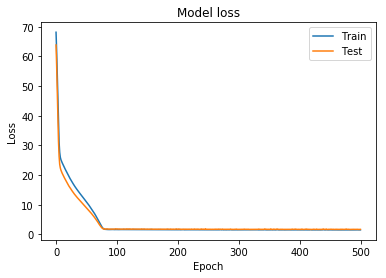

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [24]:
model.get_weights()

[array([[-0.01523345,  0.68654424,  0.05506377],
        [ 0.3932423 ,  0.62106925,  0.9738478 ],
        [ 0.7166254 ,  1.3963885 , -0.11444313]], dtype=float32),
 array([1.5747631, 1.5654247, 1.6217307], dtype=float32),
 array([[0.6290362],
        [0.3613625],
        [1.0678002]], dtype=float32),
 array([1.5132896], dtype=float32)]

## 总结

Keras可以大大加速构建神经网络，新手从Keras开始可以有效的降低Tensorflow学习曲线的陡度。使用Keras的model基于一层层的层叠加，可扩展性非常，可以看到Tensorflow要用很多行代码用keras几行就可以完成，而且层次明了。当然Keras隐藏掉许多实现细节，可能会导致对于模型的理解不够深入，另外一些复杂的模型还需要Tensorflow底层功能，使用Keras的同时建议也要对Tensorflow有一定了解。


